### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import date, time, datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from hdbcli import dbapi as db

from statsmodels.tsa.api import STLForecast, ExponentialSmoothing, ExponentialSmoothing

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

from statsmodels.tsa.api import STLForecast, ExponentialSmoothing, ETSModel

import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from pmdarima.arima import auto_arima
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


import pandas as pd
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
from openpyxl import Workbook

import pandas as pd
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
from openpyxl import Workbook

from dateutil.relativedelta import relativedelta

### Base de datos

In [2]:
conn = db.connect(address='10.0.0.110', port='30015', user='DESARROLLO', password='DevHermeco.2022')
cursor = conn.cursor()
sql ='''SELECT "AÑO",
"CANAL",
"MES",
"MATERIAL",
"AFS: COLOR",
"AFS: TALLA", 
"UNIDADES", 
"Sublínea",
"Mundo",
"Tipo de Artículo", 
"Concepto Diseño",
"Año de Venta", 
"Mes de Venta", 
"FECHA VENTA"
FROM HEP300.VW_CD_REPORTE_VENTAS_ALL_2016 \
WHERE(CANAL = 'FRANQUICIAS' OR CANAL = 'TIENDAS PROPIAS')
AND "AÑO" >= 2018
'''
df_canal = pd.read_sql_query(sql, conn)

In [ ]:
ñ

In [3]:
def XGB_model(df_model):
    # Fechas forecast
    fecha_inicial = '2023-03'
    fecha_final = '2024-02'
    
    df_model.MES_AÑO = pd.to_datetime(df_model.MES_AÑO)
    
    #  TRAIN & TEST
    train = df_model.loc[df_model.MES_AÑO < pd.to_datetime(fecha_inicial)].set_index('MES_AÑO')

    test = df_model.loc[(df_model.MES_AÑO >= pd.to_datetime(fecha_inicial)) & 
                        (df_model.MES_AÑO < pd.to_datetime(fecha_final))].set_index('MES_AÑO')


    # Define el train y test de acuerdo con las bases de datos de train y de test
    X_train, y_train = create_features_mes_venta(train, label = 'UNIDADES')
    X_test, y_test = create_features_mes_venta(test, label = 'UNIDADES')

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators = 1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,
                           eval_metric = ['rmse','mae','mape']
                           )
    
    reg.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose = False)

    pred_test = reg.predict(X_test)
    test['UNIDADES'] = np.ceil(pred_test)

    
    return test[['UNIDADES']]

In [4]:
def xgb_mes_a_mes(basicos1):
    meses_basicos = [1,2,3,4,5,6,7,8,9,10,11,12]
    basicos_forecast = {}

    basicos_results = pd.DataFrame()
    basicos1['MES'] = pd.to_datetime(basicos1['MES_AÑO']).dt.month

    for mes in meses_basicos:
        if mes in basicos1['MES'].unique():
            basicos_results = pd.concat([basicos_results, XGB_model(basicos1[basicos1['MES'] == mes])])
            
        else:
            basicos_forecast[mes] = 0

    return basicos_results

In [5]:
def calcular_Cv(basicos1):
    basicos_clasificacion = pd.DataFrame()
    meses = basicos1.MES.unique()
    # meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Calcular el factor CV para cada mes
    cv_mes = {}
    for mes in meses:
        if mes in basicos1['MES'].unique():
            cv_mes[mes] = round(basicos1[basicos1['MES'] == mes]['UNIDADES'].std()
                                / basicos1[basicos1['MES'] == mes]['UNIDADES'].mean(), 2)
        # else:
        #     cv_mes[mes] = 0


    lista_cv = []
    for i in cv_mes.values():
        lista_cv.append(i)
    
    coeficiente_Var = np.std(lista_cv)/np.mean(lista_cv)

    return round(coeficiente_Var,2)


In [6]:
basicos = df_canal[df_canal['Concepto Diseño']== 'BASICOS']

### Ejemplo

In [7]:
basicos_individual = basicos[(basicos['Mundo'] == 'NIÑA' ) &
                                        (basicos['Tipo de Artículo'] == 'CAMISA MANGA LARGA')]

basicos_individual.head(2)

,AÑO,CANAL,MES,MATERIAL,AFS: COLOR,AFS: TALLA,UNIDADES,Sublínea,Mundo,Tipo de Artículo,Concepto Diseño,Año de Venta,Mes de Venta,FECHA VENTA
672573,2018,TIENDAS PROPIAS,8,5204453,Rosado 12-1310,10,1.0,BASICOS,NIÑA,CAMISA MANGA LARGA,BASICOS,2018,FEBRERO,2018-08-25
672574,2018,TIENDAS PROPIAS,3,5204453,Rosado 12-1310,10,1.0,BASICOS,NIÑA,CAMISA MANGA LARGA,BASICOS,2018,FEBRERO,2018-03-26


#### MODELO LINEAL

In [8]:
basicos_individual['FECHA'] = pd.to_datetime(basicos_individual['FECHA VENTA']).dt.to_period('M')

In [9]:
# HISTORICO
df_model = basicos_individual.groupby('FECHA')['UNIDADES'].sum().reset_index()

In [10]:
# convert period to timestamp
df_model['FECHA'] = df_model['FECHA'].apply(lambda x: x.to_timestamp())
# assign covid column
df_model['covid'] = [1 if ((x > pd.Timestamp('2020-03')) & (x < pd.Timestamp('2021-03'))) else 0 for x in df_model.FECHA]


In [11]:
df_model['month'] = df_model['FECHA'].dt.month
df_model['year'] = df_model['FECHA'].dt.year


# Define the features and target variable
X = df_model.drop(['UNIDADES','FECHA'], axis=1)
y = df_model['UNIDADES']

In [12]:
#  Split the data into training and testing sets
split_Date_test = '2022-11-01'

train_size = df_model.loc[df_model['FECHA'] >= split_Date_test].index[0]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
tuned_parameters = {
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
        'base_score': [0.1, 0.3, 0.5],
        'eval_metric': ['rmse', 'mae', 'mape']
    }
# xgbr = XGBRegressor(learning_rate=0.3, max_depth=6, n_estimators=100,subsample=0.8)
# clf = GridSearchCV(xgbr, param_grid = tuned_parameters, cv = 5)
# clf.fit(X_train, y_train)

In [14]:
xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )

# Fit the model to the training data
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse', 'mae', 'mape'], feature_types=None, gamma=0,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [15]:
test = df_model.loc[df_model['FECHA'] >= split_Date_test]
test['forecast'] = np.ceil(xg_reg.predict(X_test))

In [16]:
y_test = test['UNIDADES'][:5]
pred_test = test['forecast'][:5]

print("R^2      ..............",   round( r2_score(y_test, pred_test),1))
print('MAPE ES  ..............',   round(MAPE(y_test, pred_test),2))
test

R^2      .............. 0.4
MAPE ES  .............. 1.5


,FECHA,UNIDADES,covid,month,year,forecast
57,2022-11-01,134.0,0,11,2022,108.0
58,2022-12-01,350.0,0,12,2022,128.0
59,2023-01-01,13.0,0,1,2023,15.0
60,2023-02-01,3.0,0,2,2023,13.0
61,2023-03-01,5.0,0,3,2023,21.0
62,2023-04-01,2.0,0,4,2023,52.0


<AxesSubplot: xlabel='FECHA'>

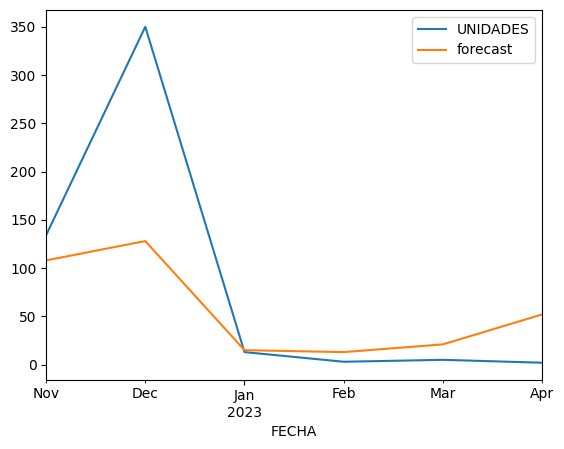

In [17]:
test.set_index('FECHA')[['UNIDADES', 'forecast']].plot()



#### MODELO MENSUAL 2022


In [18]:
# la funcion recibe todas las columnas de DF como caracteristicas y elimina el target

def create_features_mes_venta(df, label=None):

    X = df.drop(columns=[label],axis=1)

    if label:
        y = df[label]

        return X, y
        
    return X

In [19]:
# MODELO PARA METRICAS
# DF_MODEL_MONTH DEBE INCLUIR LAS SIGUIENTES COLUMNAS
# MONTH, YEAR, COVID
def XGB_model_2022(df_model_month, initial_Date=None):

    # initial_Date = '2022-11-01'

    # df_model_month = df_model_month.set_index('FECHA')
    limit_month = '2022-06-01'

    train_month = df_model_month.loc[df_model_month['FECHA'] < limit_month].set_index('FECHA')#.drop(columns={'FECHA'},axis=1)
    test_month = df_model_month.loc[df_model_month['FECHA'] >= limit_month].set_index('FECHA')#.drop(columns={'FECHA'},axis=1)

    X_train, y_train = create_features_mes_venta(train_month, label = 'UNIDADES')
    X_test, y_test = create_features_mes_venta(test_month, label = 'UNIDADES')

    xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )

    # Fit the model to the training data
    xg_reg.fit(X_train,y_train)

    test_month['forecast'] = np.ceil(xg_reg.predict(X_test))

    return  test_month


In [20]:
meses_basicos = [1,2,3,4,5,6,7,8,9,10,11,12]
basicos_forecast = {}

basicos_results = pd.DataFrame()

for mes in meses_basicos:
    if mes in df_model['month'].unique():
        df_model2 = df_model.loc[df_model['month'] == mes]
        basicos_results = pd.concat([basicos_results,XGB_model_2022(df_model[df_model['month'] == mes])])


In [21]:
basicos_results

,UNIDADES,covid,month,year,forecast
FECHA,,,,,
2023-01-01,13.0,0,1,2023,2.0
2023-02-01,3.0,0,2,2023,4.0
2023-03-01,5.0,0,3,2023,3.0
2023-04-01,2.0,0,4,2023,50.0
2022-06-01,107.0,0,6,2022,54.0
2022-07-01,102.0,0,7,2022,62.0
2022-08-01,79.0,0,8,2022,44.0
2022-09-01,59.0,0,9,2022,66.0
2022-10-01,81.0,0,10,2022,56.0


In [22]:
basicos_results.sort_index()
y_test = basicos_results['UNIDADES']
pred_test = basicos_results['forecast']

print("R^2      ..............",   round( r2_score(y_test, pred_test),1))
print('MAPE ES  ..............',   round(MAPE(y_test, pred_test),2))
basicos_results.sort_index()

R^2      .............. 0.5
MAPE ES  .............. 2.57


,UNIDADES,covid,month,year,forecast
FECHA,,,,,
2022-06-01,107.0,0,6,2022,54.0
2022-07-01,102.0,0,7,2022,62.0
2022-08-01,79.0,0,8,2022,44.0
2022-09-01,59.0,0,9,2022,66.0
2022-10-01,81.0,0,10,2022,56.0
2022-11-01,134.0,0,11,2022,92.0
2022-12-01,350.0,0,12,2022,142.0
2023-01-01,13.0,0,1,2023,2.0
2023-02-01,3.0,0,2,2023,4.0


<AxesSubplot: xlabel='FECHA'>

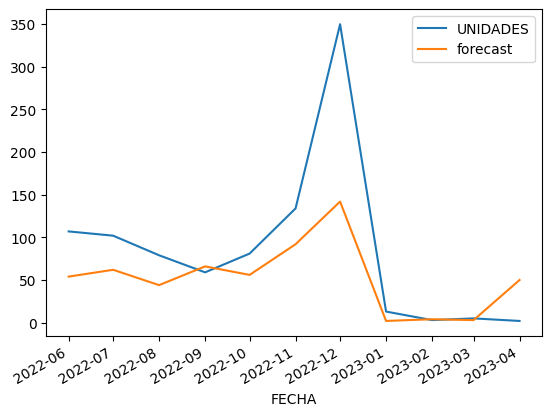

In [23]:
basicos_results[['UNIDADES','forecast']].plot()

In [24]:
df_model_month = df_model.loc[df_model['month'] == 4]
df_model_month

,FECHA,UNIDADES,covid,month,year
3,2018-04-01,389.0,0,4,2018
15,2019-04-01,196.0,0,4,2019
38,2021-04-01,66.0,0,4,2021
50,2022-04-01,50.0,0,4,2022
62,2023-04-01,2.0,0,4,2023


In [25]:
limit_month = '2023-04-01'

In [26]:
train_month = df_model_month.loc[df_model_month['FECHA'] < limit_month].drop(columns={'FECHA'},axis=1)
test_month = df_model_month.loc[df_model_month['FECHA'] >= limit_month].drop(columns={'FECHA'},axis=1)

In [27]:
X_train, y_train = create_features_mes_venta(train_month, label = 'UNIDADES')
X_test, y_test = create_features_mes_venta(test_month, label = 'UNIDADES')

In [28]:
xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )

# Fit the model to the training data
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse', 'mae', 'mape'], feature_types=None, gamma=0,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [29]:
test_month['forecast'] = np.ceil(xg_reg.predict(X_test))

In [30]:
test_month

,UNIDADES,covid,month,year,forecast
62,2.0,0,4,2023,50.0


#### MODELO DEL FUTURO MES A MES

In [31]:
df_model = df_model.loc[df_model['FECHA'] <= '2023-03-01']

In [32]:
df_model.head()

,FECHA,UNIDADES,covid,month,year
0,2018-01-01,337.0,0,1,2018
1,2018-02-01,229.0,0,2,2018
2,2018-03-01,334.0,0,3,2018
3,2018-04-01,389.0,0,4,2018
4,2018-05-01,412.0,0,5,2018


In [33]:
# MODELO PARA PRONOSTICO FUTURO
# MODELO LINEAL
# DF_MODEL_MONTH DEBE INCLUIR LAS SIGUIENTES COLUMNAS
# UNIDADES, COVID, MONTH, YEAR -- EN ESE ORDEN SIEMPRE 

def XGB_model_future(df_model_month, initial_Date=None):

    new_dates = pd.date_range(start = '2023-04-01', end='2023-10-01', freq='MS')
    new_df = pd.DataFrame({'UNIDADES':0,'covid':0,'month': new_dates.month, 'year': new_dates.year}, index=new_dates)
    new_df.index.name = 'FECHA'

    new_X = new_df.drop(['UNIDADES'], axis=1)

    limit_month = '2023-04-01'
    train_month = df_model_month.loc[df_model_month['FECHA'] < limit_month].set_index('FECHA')#.drop(columns={'FECHA'},axis=1)
    
    X_train, y_train = create_features_mes_venta(train_month, label = 'UNIDADES')

    xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )

    # Fit the model to the training data
    xg_reg.fit(X_train,y_train)

    # test_month['forecast'] = np.ceil(xg_reg.predict(X_test))
    new_df['predicted_sales'] = np.ceil(xg_reg.predict(new_X))

    return  new_df

In [34]:
# GENERA UN SOLO RESULTADO PERO SE TOMA TODO EL HISTORICO 
# PORQUE SI TOMAMOS TODOS LOS MESES ENTONCES SE REPLICA EL ULTIMO VALOR

def XGB_model_future_monthly(df_model_month, date_test):

    new_dates = pd.date_range(start = date_test, end=date_test, freq='MS')
    new_df = pd.DataFrame({'UNIDADES':0,'covid':0,'month': new_dates.month, 'year': new_dates.year}, index=new_dates)
    new_df.index.name = 'FECHA'

    new_X = new_df.drop(['UNIDADES'], axis=1)

    limit_month = '2023-04-01'
    train_month = df_model_month.loc[df_model_month['FECHA'] < limit_month].set_index('FECHA')#.drop(columns={'FECHA'},axis=1)
    
    X_train, y_train = create_features_mes_venta(train_month, label = 'UNIDADES')

    xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )

    # Fit the model to the training data
    xg_reg.fit(X_train,y_train)

    # test_month['forecast'] = np.ceil(xg_reg.predict(X_test))
    # new_df['forecast'] = np.ceil(xg_reg.predict(new_X))
    new_df['UNIDADES'] = np.ceil(xg_reg.predict(new_X))

    return  new_df[['UNIDADES']]

In [35]:
meses_basicos = [4,5,6,7,8,9,10]

basicos_results_monthly = pd.DataFrame()


# ESTE CICLO PRONOSTICA VENTAS DESDE ABRIL HASTA OCTUBRE
for mes in meses_basicos:
    
    df_model2 = df_model.loc[df_model['month'] == mes]
    
    if mes in df_model2['month'].unique():
        # Data for test 
        last_date_train = df_model2.FECHA.iloc[len(df_model2)-1] 

        date_obj = datetime.strptime(last_date_train.strftime('%Y-%m-%d'), '%Y-%m-%d')
        forecast_date = date_obj + relativedelta(years=1)
        
        final_date_test = datetime.strftime(forecast_date, '%Y-%m-%d')
        basicos_results_monthly = pd.concat([basicos_results_monthly,XGB_model_future_monthly(df_model, final_date_test)])
        basicos_results_monthly['tipo'] = 'CAMISA MANGA LARGA'
        basicos_results_monthly['MUNDO'] = 'NIÑA'
    else:
        continue

In [36]:
basicos_results_monthly

,UNIDADES,tipo,MUNDO
FECHA,,,
2023-04-01,45.0,CAMISA MANGA LARGA,NIÑA
2023-05-01,77.0,CAMISA MANGA LARGA,NIÑA
2023-06-01,91.0,CAMISA MANGA LARGA,NIÑA
2023-07-01,80.0,CAMISA MANGA LARGA,NIÑA
2023-08-01,55.0,CAMISA MANGA LARGA,NIÑA
2023-09-01,53.0,CAMISA MANGA LARGA,NIÑA
2023-10-01,66.0,CAMISA MANGA LARGA,NIÑA


#### BASICOS PARA NIÑA

In [37]:
df_canal['FECHA'] = pd.to_datetime(df_canal['FECHA VENTA']).dt.to_period('M')

In [38]:
basicos = df_canal.loc[df_canal['Concepto Diseño'] == 'BASICOS']

In [39]:
tipos = basicos['Tipo de Artículo'].unique()
mundos =  basicos['Mundo'].unique()

# tipos = ['CAMISA MANGA LARGA', 'PANTALON']

In [40]:
single_data = basicos.loc[basicos['Mundo'] == 'NIÑA']
single_data = single_data.loc[single_data['Tipo de Artículo'] == 'PANTALON']
single_data.to_excel('ejemplo.xlsx')


df_model = single_data.groupby('FECHA')['UNIDADES'].sum().reset_index()
df_model['FECHA'] = df_model['FECHA'].apply(lambda x: x.to_timestamp())
df_model = df_model.loc[df_model['FECHA'] <= '2023-03-01']

df_model['covid'] = [1 if ((x > pd.Timestamp('2020-03')) & (x < pd.Timestamp('2021-03'))) else 0 for x in df_model.FECHA]
df_model['month'] = df_model['FECHA'].dt.month
df_model['year'] = df_model['FECHA'].dt.year

print(df_model.head(5))

       FECHA  UNIDADES  covid  month  year
0 2018-01-01       3.0      0      1  2018
1 2018-02-01     148.0      0      2  2018
2 2018-03-01     258.0      0      3  2018
3 2018-04-01     253.0      0      4  2018
4 2018-05-01     319.0      0      5  2018


In [41]:
single_data = basicos.loc[basicos['Mundo'] == 'NIÑO']
single_data = single_data.loc[single_data['Tipo de Artículo'] == 'BALETA']

df_model = basicos_individual.groupby('FECHA')['UNIDADES'].sum().reset_index()
df_model['FECHA'] = df_model['FECHA'].apply(lambda x: x.to_timestamp())
df_model = df_model.loc[df_model['FECHA'] <= '2023-03-01']

df_model['covid'] = [1 if ((x > pd.Timestamp('2020-03')) & (x < pd.Timestamp('2021-03'))) else 0 for x in df_model.FECHA]
df_model['month'] = df_model['FECHA'].dt.month
df_model['year'] = df_model['FECHA'].dt.year

meses_basicos = [4,5,6,7,8,9,10]
basicos_results_monthly = pd.DataFrame()

# opcion 1
basicos_results_Linear = pd.DataFrame()
basicos_results_Linear = pd.concat([basicos_results_Linear,XGB_model_future(df_model)])
basicos_results_Linear = basicos_results_Linear.sort_index()

# print(basicos_results_monthly)

# OPCION 2 
# ESTE CICLO PRONOSTICA VENTAS DESDE ABRIL HASTA OCTUBRE

for mes in meses_basicos:
        
    df_model2 = df_model.loc[df_model['month'] == mes]
    
    if mes in df_model2['month'].unique():
        # Data for test 
        last_date_train = df_model2.FECHA.iloc[len(df_model2)-1] 

        date_obj = datetime.strptime(last_date_train.strftime('%Y-%m-%d'), '%Y-%m-%d')
        forecast_date = date_obj + relativedelta(years=1)
        
        final_date_test = datetime.strftime(forecast_date, '%Y-%m-%d')
        basicos_results_monthly = pd.concat([basicos_results_monthly,XGB_model_future_monthly(df_model2, final_date_test)])
        basicos_results_monthly = basicos_results_monthly.sort_index()

In [42]:
import plotly.graph_objs as go

# Assuming df_model and basicos_results_monthly are your DataFrames
fig = go.Figure()

# Add a trace for the UNIDADES column of df_model
fig.add_trace(
    go.Scatter(x=basicos_results_Linear.index, y=basicos_results_Linear['predicted_sales'], name='lineal')
)

# Add a trace for the UNIDADES column of basicos_results_monthly
fig.add_trace(
    go.Scatter(x=basicos_results_monthly.index, y=basicos_results_monthly['UNIDADES'], name='basicos_results_monthly')
)

# Set the title and axis labels
fig.update_layout(
    title='UNIDADES vs FECHA',
    xaxis_title='FECHA',
    yaxis_title='UNIDADES'
)

# Show the plot
fig.show()

In [43]:
ñ

NameError: name 'ñ' is not defined

In [ ]:
basicos_niña = pd.DataFrame()

for tipo in tipos:
    single_data = basicos.loc[basicos['Mundo'] == 'NIÑA']
    single_data = single_data.loc[single_data['Tipo de Artículo'] == tipo]

    single_data['FECHA'] = pd.to_datetime(single_data['FECHA VENTA']).dt.to_period('M')

    df_model = single_data.groupby('FECHA')['UNIDADES'].sum().reset_index()

    df_model['FECHA'] = df_model['FECHA'].apply(lambda x: x.to_timestamp())
    df_model = df_model.loc[df_model['FECHA'] <= '2023-03-01']
    
    df_model['covid'] = [1 if ((x > pd.Timestamp('2020-03')) & (x < pd.Timestamp('2021-03'))) else 0 for x in df_model.FECHA]
    df_model['month'] = df_model['FECHA'].dt.month
    df_model['year'] = df_model['FECHA'].dt.year
    
    # print(df_model.tail(5))

    if(len(df_model) < 15):
        continue
    else:
        # print(tipo)
        meses_basicos = [4,5,6,7,8,9,10]
        basicos_results_monthly = pd.DataFrame()

        basicos_results_monthly = pd.concat([basicos_results_monthly,XGB_model_future(df_model,)])
        basicos_results_monthly['TIPO'] = tipo
        basicos_results_monthly['MUNDO'] = 'NIÑA'
        basicos_results_monthly = basicos_results_monthly.sort_index()

        # print(basicos_results_monthly)

        # ESTE CICLO PRONOSTICA VENTAS DESDE ABRIL HASTA OCTUBRE
        
        for mes in meses_basicos:
            
            df_model2 = df_model.loc[df_model['month'] == mes]
            
            if mes in df_model2['month'].unique():
                # Data for test 
                last_date_train = df_model2.FECHA.iloc[len(df_model2)-1] 

                date_obj = datetime.strptime(last_date_train.strftime('%Y-%m-%d'), '%Y-%m-%d')
                forecast_date = date_obj + relativedelta(years=1)
                
                final_date_test = datetime.strftime(forecast_date, '%Y-%m-%d')
                basicos_results_monthly = pd.concat([basicos_results_monthly,XGB_model_future_monthly(df_model, final_date_test)])
                basicos_results_monthly['TIPO'] = tipo
                basicos_results_monthly['MUNDO'] = 'NIÑA'
                basicos_results_monthly = basicos_results_monthly.sort_index()
            else:
                continue
    # print(basicos_results_monthly)



In [ ]:
basicos_results_monthly

In [ ]:
ñ

NameError: name 'ñ' is not defined

In [ ]:
basicos_results_monthly

,UNIDADES,TIPO,MUNDO
FECHA,,,
2023-04-01,45.0,PANTALON,NIÑA
2023-05-01,77.0,PANTALON,NIÑA
2023-06-01,91.0,PANTALON,NIÑA
2023-07-01,80.0,PANTALON,NIÑA
2023-08-01,55.0,PANTALON,NIÑA
2023-09-01,53.0,PANTALON,NIÑA
2023-10-01,66.0,PANTALON,NIÑA


In [ ]:
import plotly.graph_objs as go

# Assuming df_model and basicos_results_monthly are your DataFrames
fig = go.Figure()

# Add a trace for the UNIDADES column of df_model
fig.add_trace(
    go.Scatter(x=df_model.FECHA, y=df_model['UNIDADES'], name='df_model')
)

# Add a trace for the UNIDADES column of basicos_results_monthly
fig.add_trace(
    go.Scatter(x=basicos_results_monthly.index, y=basicos_results_monthly['UNIDADES'], name='basicos_results_monthly')
)

# Set the title and axis labels
fig.update_layout(
    title='UNIDADES vs FECHA',
    xaxis_title='FECHA',
    yaxis_title='UNIDADES'
)

# Show the plot
fig.show()


,UNIDADES,TIPO,MUNDO
FECHA,,,
2023-04-01,45.0,BOLSITA,NIÑA
2023-05-01,77.0,BOLSITA,NIÑA
2023-06-01,91.0,BOLSITA,NIÑA
2023-07-01,80.0,BOLSITA,NIÑA
2023-08-01,55.0,BOLSITA,NIÑA
2023-09-01,53.0,BOLSITA,NIÑA
2023-10-01,66.0,BOLSITA,NIÑA


In [ ]:
basicos[(basicos['Mundo'] == 'NIÑA' ) &
                                        (basicos['Tipo de Artículo'] == 'CAMISA MANGA LARGA')]

#### NUEVOS DATOS FUTUROS LINEAL


In [ ]:
new_dates = pd.date_range(start = '2023-04-01', end='2023-10-01', freq='MS')
new_df = pd.DataFrame({'UNIDADES':0,'month': new_dates.month, 'year': new_dates.year,'covid':0})

In [ ]:
new_X = new_df.drop(['UNIDADES'], axis=1)
new_df['predicted_sales'] = np.ceil(xg_reg.predict(new_X))
new_df

,UNIDADES,month,year,covid,predicted_sales
0,0,4,2023,0,50.0
1,0,5,2023,0,50.0
2,0,6,2023,0,50.0
3,0,7,2023,0,50.0
4,0,8,2023,0,50.0
5,0,9,2023,0,50.0
6,0,10,2023,0,50.0


In [ ]:
ñññññññ

NameError: name 'ñññññññ' is not defined

# DELETE

In [ ]:
fecha_inicial = '2023-03'
fecha_final = '2024-02'

basicos_individual['MES_AÑO'] = pd.to_datetime(basicos_individual['AÑO'].astype(str) + 
                            '-' + basicos_individual['MES'].astype(str)).dt.strftime('%Y-%m')

# df_model.MES_AÑO = pd.to_datetime(df_model.MES_AÑO)

# #  TRAIN & TEST
train = basicos_individual.loc[basicos_individual.MES_AÑO < pd.to_datetime(fecha_inicial)].set_index('MES_AÑO')

test = basicos_individual.loc[(basicos_individual.MES_AÑO >= pd.to_datetime(fecha_inicial)) & 
                    (basicos_individual.MES_AÑO < pd.to_datetime(fecha_final))].set_index('MES_AÑO')



 # Define el train y test de acuerdo con las bases de datos de train y de test
# X_train, y_train = create_features(train)
# X_test, y_test = create_features(test)

# reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                         n_estimators = 1000,
#                         early_stopping_rounds=50,
#                         objective='reg:squarederror',
#                         max_depth=3,
#                         learning_rate=0.01,
#                         eval_metric = ['rmse','mae','mape']
#                         )

# reg.fit(X_train,y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     verbose = False)

# pred_test = reg.predict(X_test)
# test['UNIDADES'] = np.ceil(pred_test)

In [ ]:
# meses pronostico
meses_basicos = [1,2,3,4,5,6,7,8,9,10,11,12]
basicos_results = pd.DataFrame()

for mes in meses_basicos:
    if mes in basicos_individual2['MES'].unique():
        df_month = df_model[df_model['MES'] == mes]
        basicos_results = pd.concat([basicos_results, df_model[df_model['MES'] == mes]])



In [ ]:
(df_month)

In [ ]:
test = df_month.loc[(df_month.MES_AÑO >= pd.to_datetime(fecha_inicial)) & 
                    (df_month.MES_AÑO < pd.to_datetime(fecha_final))].set_index('MES_AÑO')
test

In [ ]:
fecha_inicial = '2023-03'
fecha_final = '2024-02'

df_model.MES_AÑO = pd.to_datetime(df_model.MES_AÑO)

#  TRAIN & TEST
train = df_month.loc[df_month.MES_AÑO < pd.to_datetime(fecha_inicial)].set_index('MES_AÑO')

test = df_month.loc[(df_month.MES_AÑO >= pd.to_datetime(fecha_inicial)) & 
                    (df_month.MES_AÑO < pd.to_datetime(fecha_final))].set_index('MES_AÑO')



 # Define el train y test de acuerdo con las bases de datos de train y de test
X_train, y_train = create_features_mes_venta(train, label = 'UNIDADES')
X_test, y_test = create_features_mes_venta(test, label = 'UNIDADES')

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators = 1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01,
                        eval_metric = ['rmse','mae','mape']
                        )

reg.fit(X_train,y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose = False)

pred_test = reg.predict(X_test)
test['UNIDADES'] = np.ceil(pred_test)


In [ ]:
pd.concat([train,test])

In [ ]:
ññññ

In [ ]:


basicos_forecast = {}

basicos_results = pd.DataFrame()

for mes in meses_basicos:
    if mes in basicos_individual2['MES'].unique():
        basicos_results = pd.concat([basicos_results, XGB_model(df_model[df_model['MES'] == mes])])
    else:
        basicos_forecast[mes] = 0
        basicos_results = pd.concat([basicos_results, pd.DataFrame.from_dict({'MES_AÑO': [(mes)], 'UNIDADES': [0]}).set_index('MES_AÑO')])

In [ ]:
basicos_results

In [ ]:
pd.concat([df_model,basicos_results])

In [ ]:
basicos_results.sort_index()

#### todos

In [ ]:
basicos_results = pd.DataFrame()
basicos_results_final = pd.DataFrame()
c = 0

mundos = ['NIÑA','NIÑO','BEBÉ NIÑO','BEBÉ NIÑA','PRIMI NIÑO','PRIMI NIÑA']
tipos = ['SANDALIA','VESTIDO MANGA LARGA','CAMISA MANGA LARGA','OVERALL CORTO', 'OVERALL CORTO','DENIM']


for mundo in mundos:
    # output_file = f"basicos_resultados_{mundo}.xlsx"
    
    basicos_results_final = pd.DataFrame()
    for tipo in basicos['Tipo de Artículo'].unique():
    # for tipo in tipos:

        basicos_individual = basicos[(basicos['Mundo'] == mundo ) &
                                        (basicos['Tipo de Artículo'] == tipo)]


        basicos_individual2 = basicos_individual.groupby(['MES', 'AÑO'])[
        'UNIDADES'].sum().to_frame().sort_values(by=['AÑO', 'MES']).reset_index()


        basicos_individual2['MES_AÑO'] = pd.to_datetime(basicos_individual2['AÑO'].astype(str) + 
                                    '-' + basicos_individual2['MES'].astype(str))#.dt.strftime('%Y-%m')
        
        if(len(basicos_individual2) >= 15):

            df_model = pd.concat([basicos_individual2,test_df], axis=0, ignore_index=True)
    
            meses_basicos = [1,2,3,4,5,6,7,8,9,10,11,12]
            basicos_forecast = {}

            basicos_individual2['MES'] = pd.to_datetime(basicos_individual2['MES_AÑO']).dt.month
            
            # basicos_results = pd.concat([basicos_results, XGB_model(df_model)])

            for mes in meses_basicos:
                if mes in basicos_individual2['MES'].unique():
                    basicos_results = pd.concat([basicos_results, XGB_model(df_model[df_model['MES'] == mes])])
                else:
                    basicos_forecast[mes] = 0
                    basicos_results = pd.concat([basicos_results, pd.DataFrame.from_dict({'MES_AÑO': [mes], 'UNIDADES': [0]}).set_index('MES_AÑO')])

            basicos_results2 = basicos_results.reset_index()
            
            
            basicos_results2['MES_AÑO'] = pd.to_datetime(basicos_results2['MES_AÑO'].astype(str))#.dt.strftime('%Y-%m')
            basicos_results2['mundo'] = mundo
            basicos_results2['tipo'] = tipo
            basicos_results2['cv'] = calcular_Cv(basicos_individual2)
            basicos_results2 = basicos_results2.sort_values(by='MES_AÑO')
                        
            if(len(basicos_results)> 10):
                basicos_results_final =  basicos_results_final.append(basicos_results2, ignore_index= True)
                # print(basicos_results_final.columns,basicos_results_final.index)
                basicos_results = pd.DataFrame()

        else:
            continue

        # with pd.ExcelWriter(output_file) as writer:
        #     basicos_results_final.to_excel(writer, sheet_name=mundo, index=False)
    # data_frame2.to_excel(writer, sheet_name="Vegetables", index=False)
    # data_frame3.to_excel(writer, sheet_name="Baked Items", index=False)

In [ ]:
basicos_results_final.to_excel('BASICOS_NIÑA.xslx')

In [ ]:
Ñ

In [ ]:
basicos_results

In [ ]:
basicos_individual2['MES_AÑO'] = pd.to_datetime(basicos_individual2['MES_AÑO'])
basicos_individual2[['MES_AÑO','UNIDADES']]

In [ ]:
results = basicos_individual2[['MES_AÑO','UNIDADES']].merge(
    basicos_results.reset_index().rename(columns={'UNIDADES':'FORECAST'}),
    on= 'MES_AÑO'
)

In [ ]:
results['diferencia'] = np.ceil(abs(results['UNIDADES']- results['FORECAST']))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
print('MAPE ES  ..............',   round(MAPE(results['UNIDADES'], results['FORECAST']),2))

In [ ]:
results

In [ ]:
results.set_index('MES_AÑO').plot()